In [1]:
%matplotlib inline
from datetime import date
from l1 import l1
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as sp_signal
from sklearn import ensemble
import statsmodels.api as sm

plt.style.use('fivethirtyeight')

_DATA_DIR = 'data'
_FIG_DIR = 'figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)

_SNP_500_PATH = os.path.join(_DATA_DIR, 'snp500.csv')
_BEGINNING_DATE = date(2014, 1, 1)

## Matplotlib Variables
_FIG_SIZE = (16, 12)
_FIG_FORMAT = 'png'
_FIG_DPI = 200
_FIG_LEGEND_LOCATION = 4

_ORIGINAL_SIGNAL_LABEL = 'Original Signal'
_MEAN_AVERAGE_SIGNAL_LABEL = 'Mean Averaged Signal'
_MEDIAN_FILTERED_SIGNAL_LABEL = 'Median Filtered Signal'
_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL = 'Exponential Moving Averaged Signal'
_SNP_CYCLE_SIGNAL_LABEL = 'Cycle Signal'
_SNP_TREND_SIGNAL_LABEL = 'Trend'
_L1_TREND_SIGNAL_LABEL = '$l_1$ Trend'
_BAND_PASS_FILTER_LABEL = 'Band-pas filtered'


_BUTTERWORTH_FILTER_TITLE = 'Butterworth filter frequency response'
_BUTTERWORTH_FILTER_XLABEL = 'Frequency [radians / second]'
_BUTTERWORTH_FILTER_YLABEL = 'Amplitude [dB]'

_MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE = 'Mean Average signal with window = {}'.format
_MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE = 'Median Filtered signal with window = {}'.format
_EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE = 'Exponential Smoothed signal with span = {}'.format
_HODRICK_PRESSCOTT_TITLE_TEMPLATE = 'Trend and Cycle Signal with smoothing parameter: {}'.format
_L1_TITLE_TEMPLATE = '$l_1$ Trend Signal with regularizer: {}'.format
_BAND_PASS_TITLE_TEMPLATE = 'Band-pass order: {}, low - high cutoff frequency: {} - {}'.format

### Data Explanation
- The S&P 500, or the Standard & Poor's 500, is an American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE or NASDAQ. 
- The S&P 500 index components and their weightings are determined by S&P Dow Jones Indices. 
- It differs from other U.S. stock market indices, such as the Dow Jones Industrial Average or the Nasdaq Composite index, because of its diverse constituency and weighting methodology. 
- It is one of the most commonly followed equity indices, and many consider it one of the best representations of the U.S. stock market, and a bellwether for the U.S. economy. 
- The National Bureau of Economic Research has classified common stocks as a leading indicator of __business cycles__.

Reference: http://www.albany.edu/cer/bc/bc_essays.html

In [2]:
def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

In [3]:
df = pd.read_csv(_SNP_500_PATH, parse_dates=['Date'])
df = df.sort(['Date'])
df = df[df.Date > _BEGINNING_DATE]

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
382,2014-01-02,1845.859985,1845.859985,1827.739990,1831.979980,3080600000,1831.979980
381,2014-01-03,1833.209961,1838.239990,1829.130005,1831.369995,2774270000,1831.369995
380,2014-01-06,1832.310059,1837.160034,1823.729980,1826.770020,3294850000,1826.770020
379,2014-01-07,1828.709961,1840.099976,1828.709961,1837.880005,3511750000,1837.880005
378,2014-01-08,1837.900024,1840.020020,1831.400024,1837.489990,3652140000,1837.489990


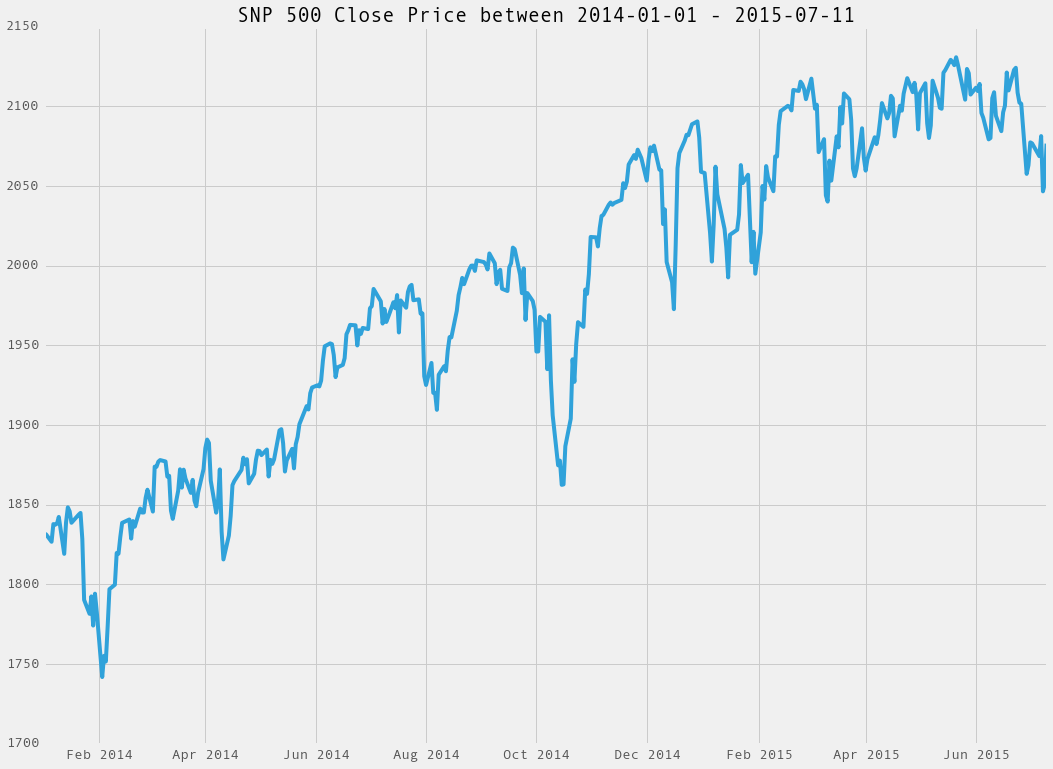

In [5]:
title = 'SNP 500 Close Price between {} - 2015-07-11'.format(_BEGINNING_DATE)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-');
plt.title(title);
plt.savefig(fig_path, dpi=_FIG_DPI)

### Moving Average Filtering

For a window size: $N$, the computation is pretty straightforward. Applying window on top of the original signal and average the signal for a given time window. Following formula assumes that $N$ being odd.

$$y(t) = \frac{\displaystyle\sum_{i=-\frac{N+1}{2}}^{\frac{N+1}{2}} x(t + i)}{w} $$

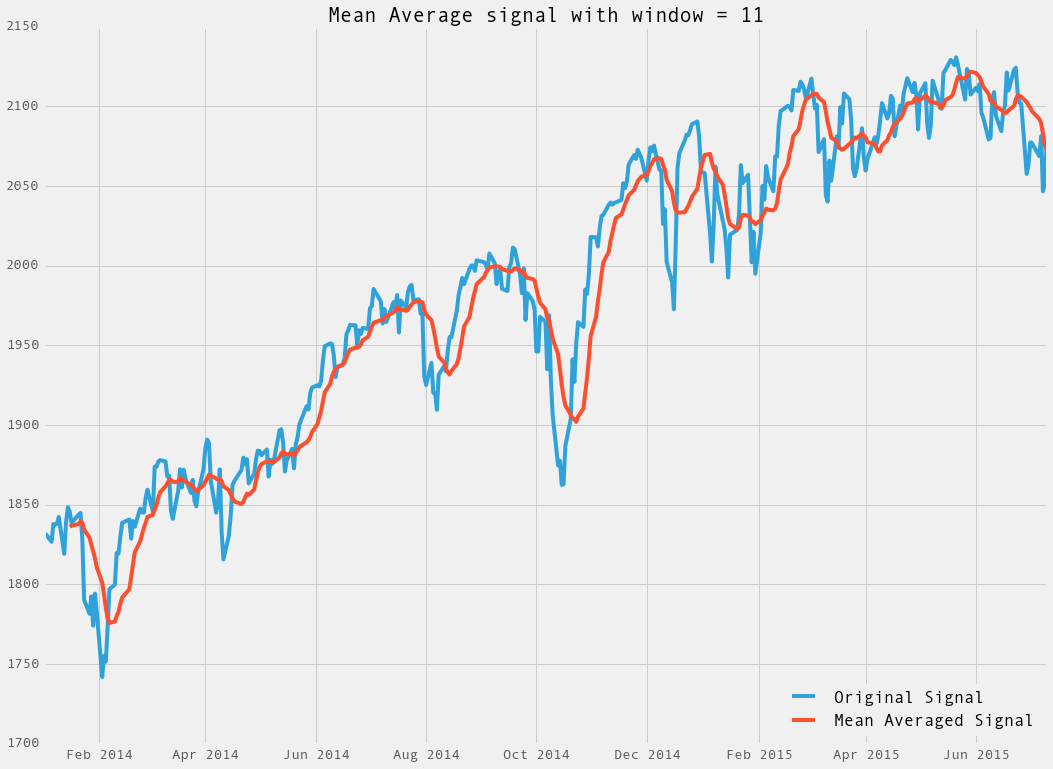

In [6]:
window = 11
title = _MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.rolling_mean(df.Close, window), '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

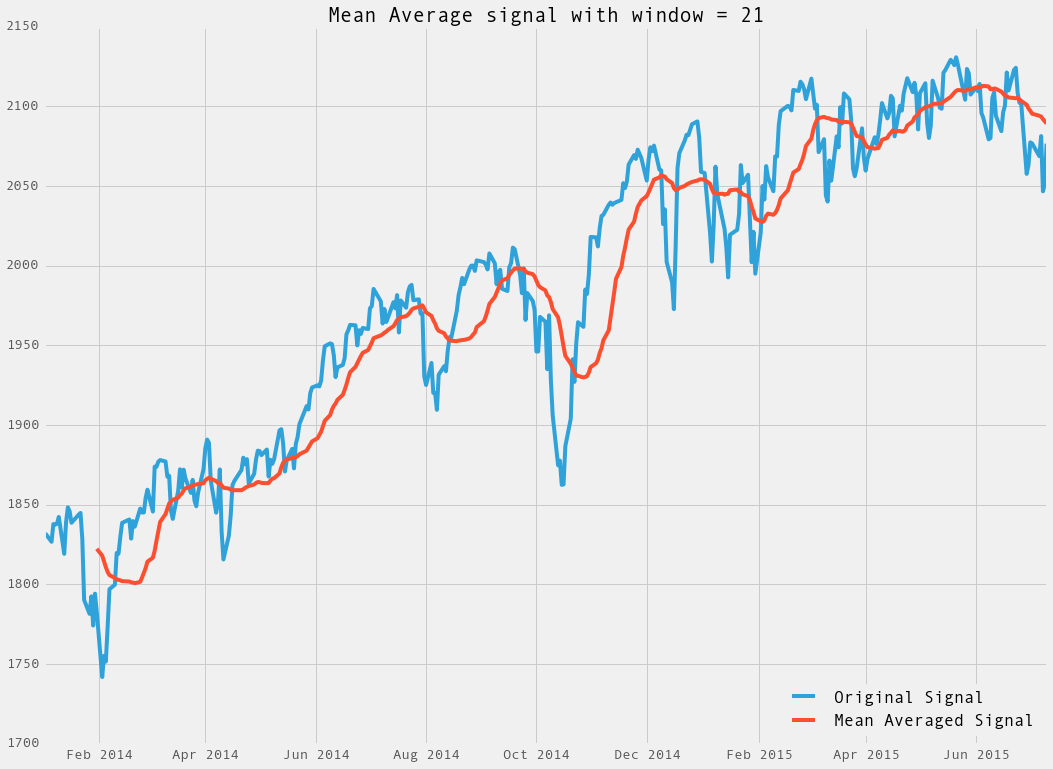

In [7]:
window = 21
title = _MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.rolling_mean(df.Close, window), '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

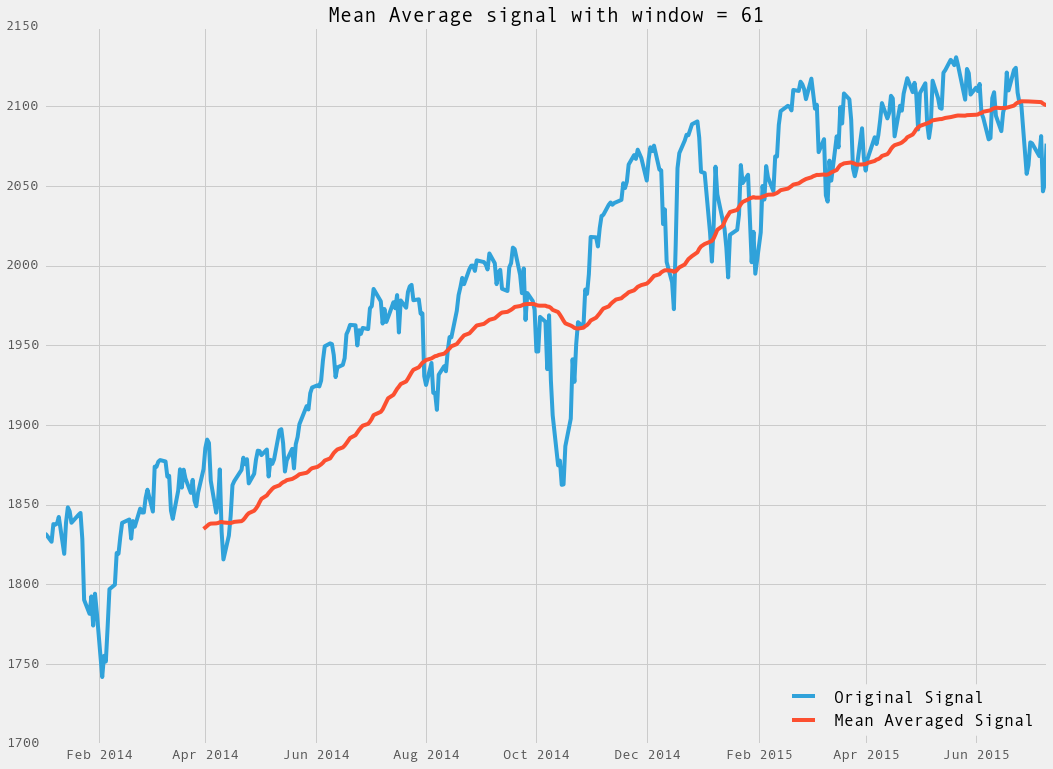

In [8]:
window = 61
title = _MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.rolling_mean(df.Close, window), '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

#### Good to Know for Moving Average 
- Linear
- Not really a trend estimation method, but provides baseline
- If the window size is small, it removes high volatility part in the signal
- If the window size is large, it exposes the long-term trend
- Not robust to outliers and abrupt changes for small and medium window sizes

## Median Filter

$$ y(t) = median( x[t-\frac{w}{2}, t+\frac{w}{2}])$$

where $w$ is the window size whose median will replace the original data point


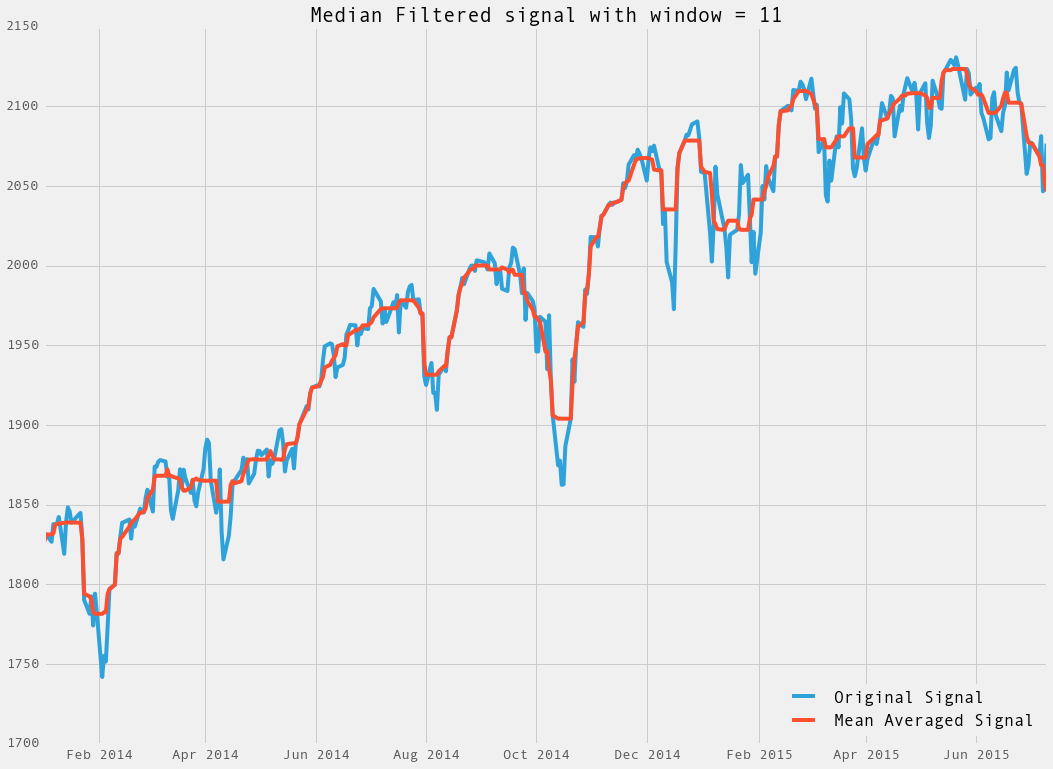

In [9]:
window = 11
median_filtered_signal = sp_signal.medfilt(df.Close, window)
title = _MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, median_filtered_signal, '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

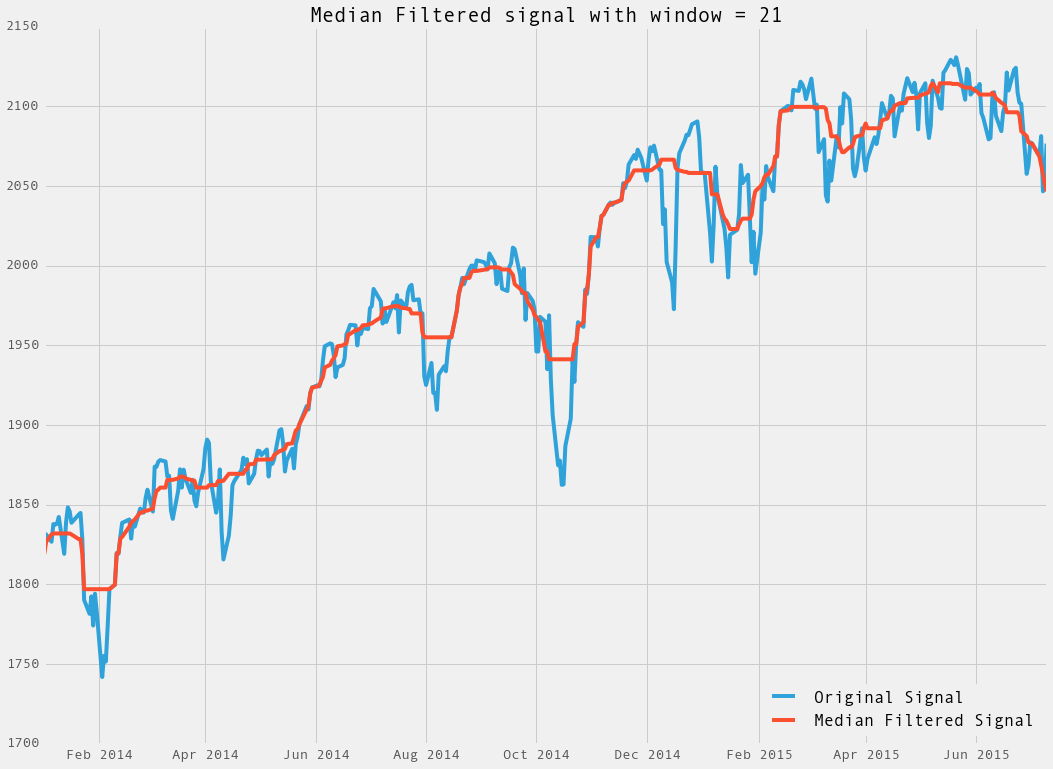

In [10]:
window = 21
median_filtered_signal = sp_signal.medfilt(df.Close, window)
title = _MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, median_filtered_signal, '-', label=_MEDIAN_FILTERED_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

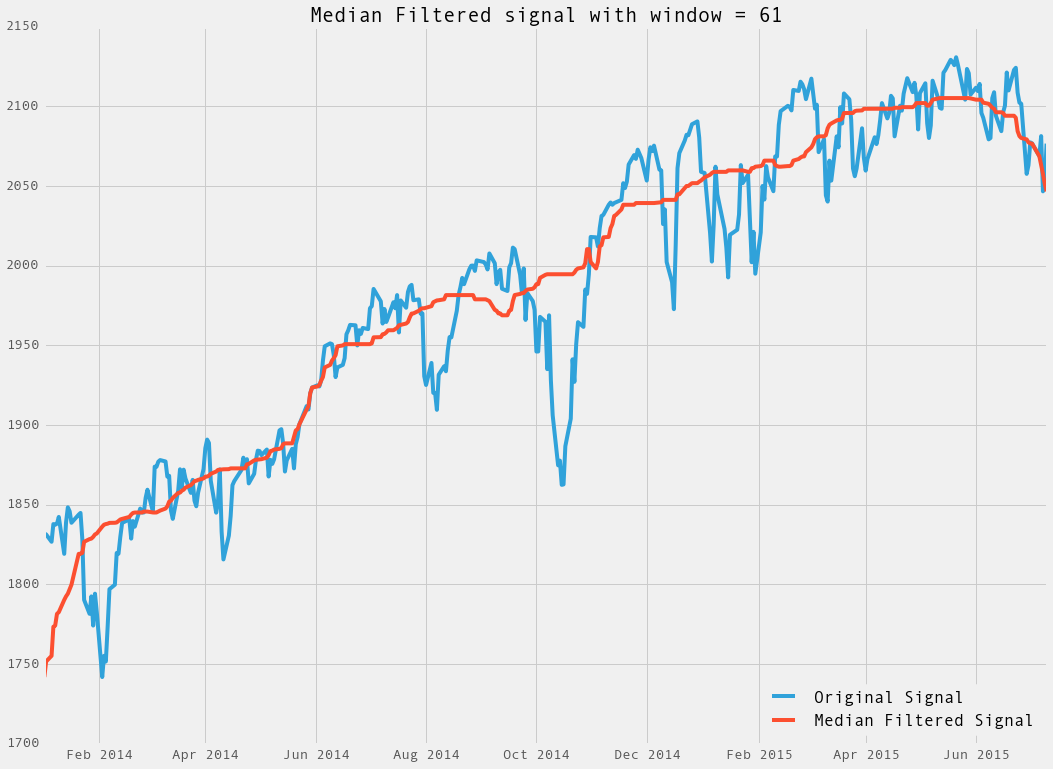

In [11]:
window = 61
median_filtered_signal = sp_signal.medfilt(df.Close, window)
title = _MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, median_filtered_signal, '-', label=_MEDIAN_FILTERED_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

#### Good to Know for Median Filter
- Nonlinear
- Very robust to noise
- If the window size is very large, it could _shadow_ mid-term change
- Trend signal may not be smooth(actually rarely is in practice)

## Exponential Weighted Moving Average (EWMA)

$$ y_t = \frac{\displaystyle\sum_i^t w_i x_{t-i}}{\displaystyle\sum_i^t w_i} $$

$$ w_i = \left\{
     \begin{array}{lr}
       \alpha (1 - \alpha)^i & i \lt t\\
       (1 - \alpha)^i & i = t
     \end{array}
   \right.
$$


$$ \alpha = \left\{
     \begin{array}{lr}
       \frac{2}{s+1} & \text{s=span}\\
       \frac{1}{c+1} & \text{c=center of mass}\\
       (1 - e^{\frac{log 0.5}{h}}) & \text{h = half life}
     \end{array}
   \right.
$$

One can think the exponential weights in terms of span and half life. Half life signifies when the weight becomes half of the max and span is how many days it spans when you get the average of signal with weights. 

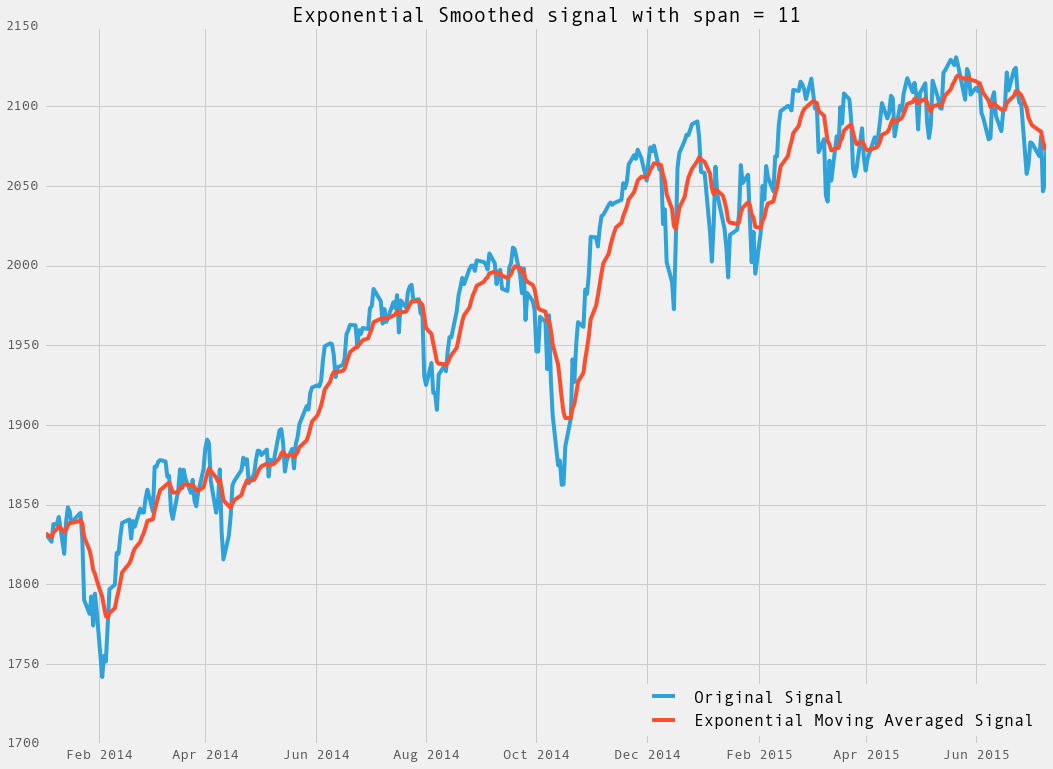

In [12]:
## Exponential Weighted Moving Average
span = 11
title = _EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE(span)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.stats.moments.ewma(df.Close, span=span), '-', label=_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

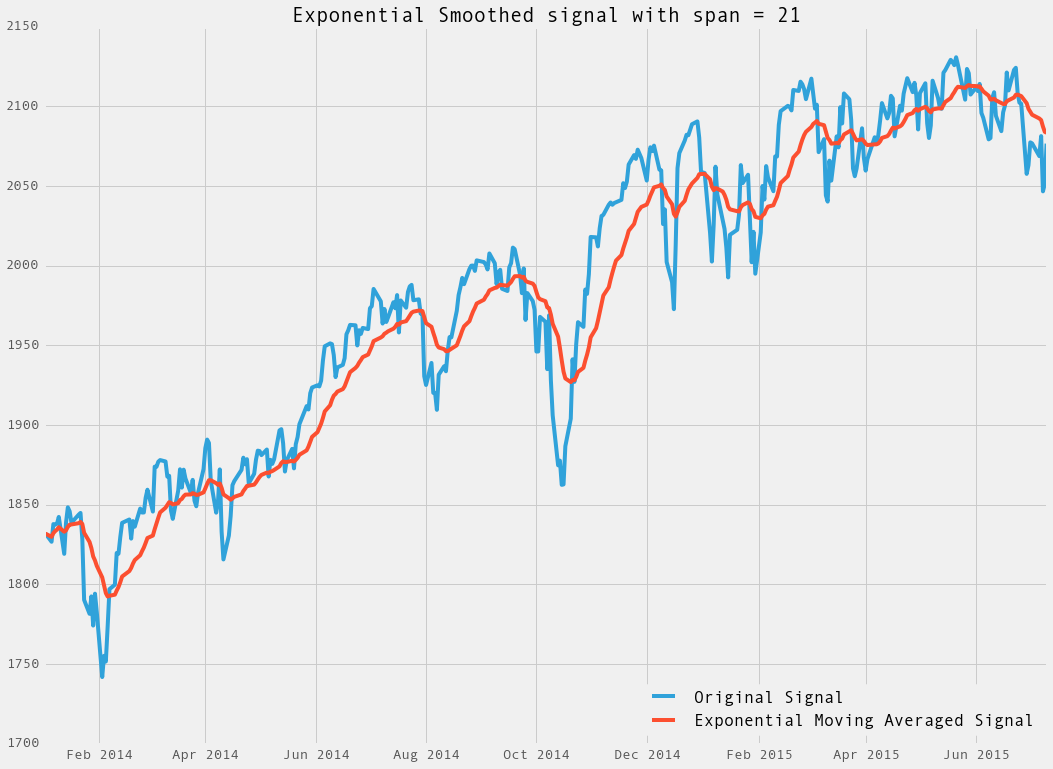

In [13]:
## Exponential Weighted Moving Average
span = 21
title = _EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE(span)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.stats.moments.ewma(df.Close, span=span), '-', label=_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

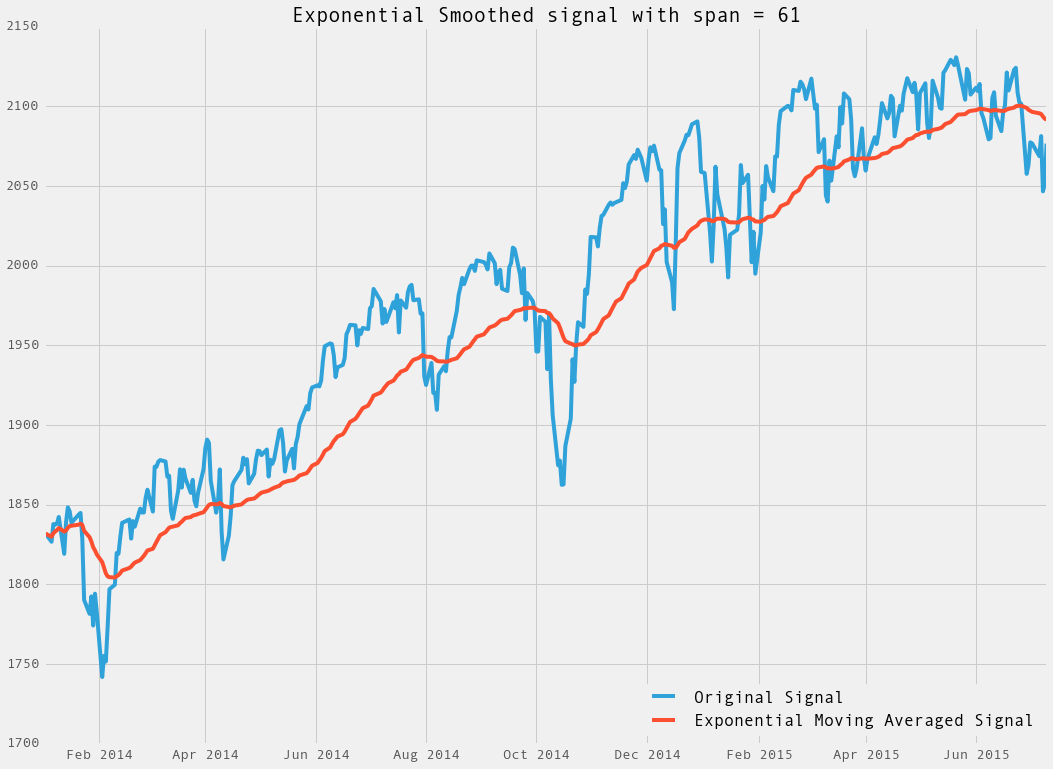

In [14]:
## Exponential Weighted Moving Average
span = 61
title = _EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE(span)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.stats.moments.ewma(df.Close, span=span), '-', label=_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

#### Good to Know for EWMA
- Linear
- Could provide a better estimate than a simple moving average because the weights
are better distributed
- Not robust to outliers and abrupt changes
- Very flexible in terms of weights and puts more emphasis on the spatial window
in the signal

## Hodrick-Prescott Filter
There are various ways to do trend estimation methods, you could decompose the signal into two compoenent; one cycle part(which is short-term) and one trend part(which is medium-to-long term), which is what Hodrick-Prescott Filter tries to do.

Hodrick Prescott filter is a bandpass filter where it tries to decompose the time-series signal into a trend $x_t$ (mid-term growth) and a cylical component(recurring and seasonal signal) $c_t$.  

$$y_t = x_t + c_t$$

The loss function that it tries to minimize is the following:

$$\min_{\\{ x_{t}\\} }\sum_{t}^{T} c_{t}^{2}+\lambda\displaystyle\sum_{t=1}^{T}\left[\left(x_{t}- x_{t-1}\right)-\left(x_{t-1}-x_{t-2}\right)\right]^{2}$$

The first term is the square of difference of original signal and growth signal(cylical component) and $\lambda$ is the smoothing parameter. 

Based on the smoothing parameter, you could actually change what type of effects you may want to include or capture(if you want to capture some variation and volatility in short-term signal, then you may want to use a smaller smoothing parameter so that you have less smooth signal. If you want to also capture only a long term range signal, the smoothing parameter could be chosen arbitrarily large. However, in order to get some changes, we need to not to choose very large smoothing optimization parameter. 

I wrote this method in detail [here](http://bugra.github.io/work/notes/2014-11-24/trend-estimation-via-hodrick-prescott-filter/).

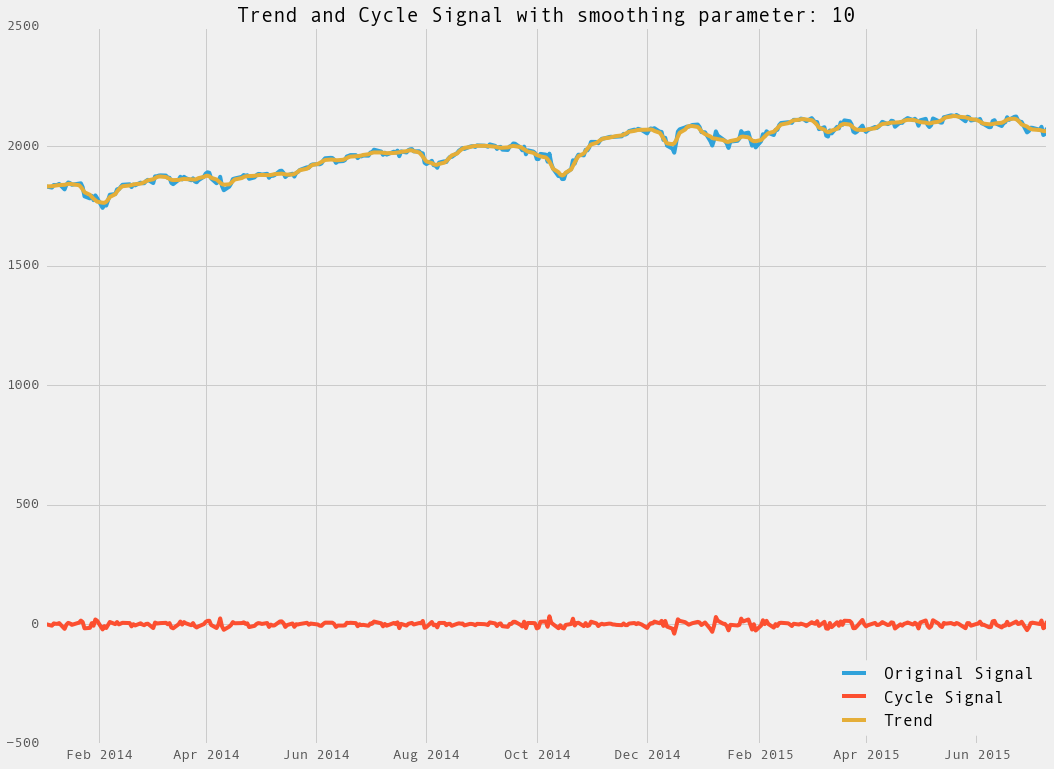

In [15]:
lamb = 10
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df.Close, lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

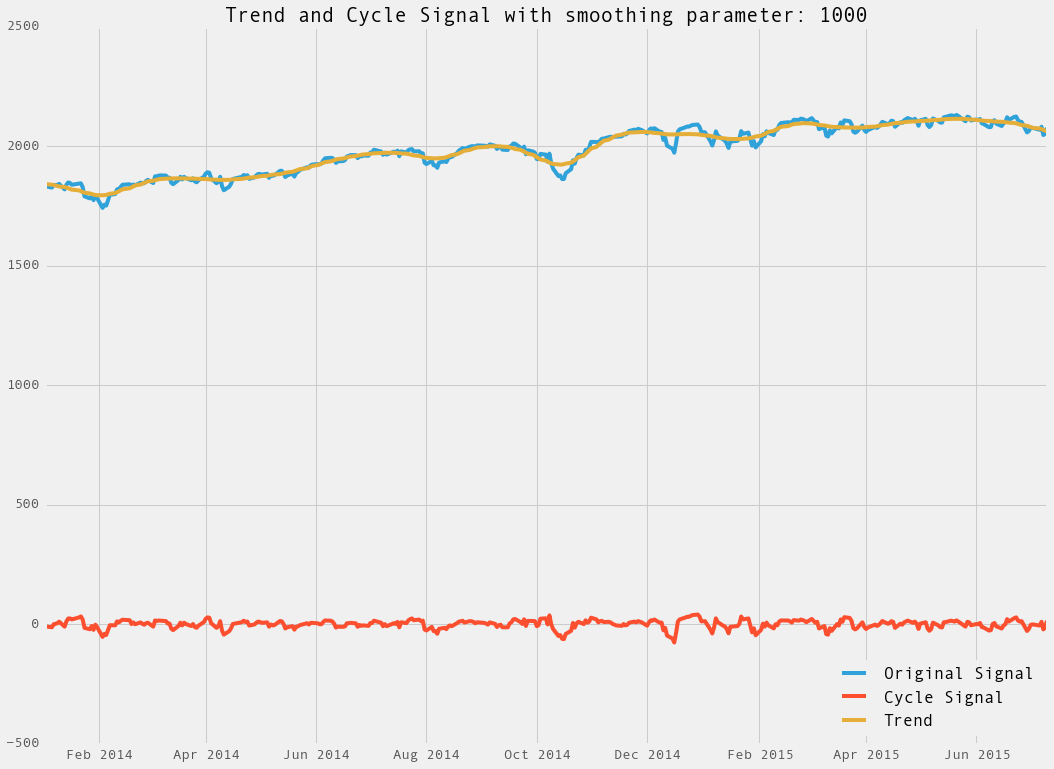

In [16]:
lamb = int(1e3)
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df.Close, lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

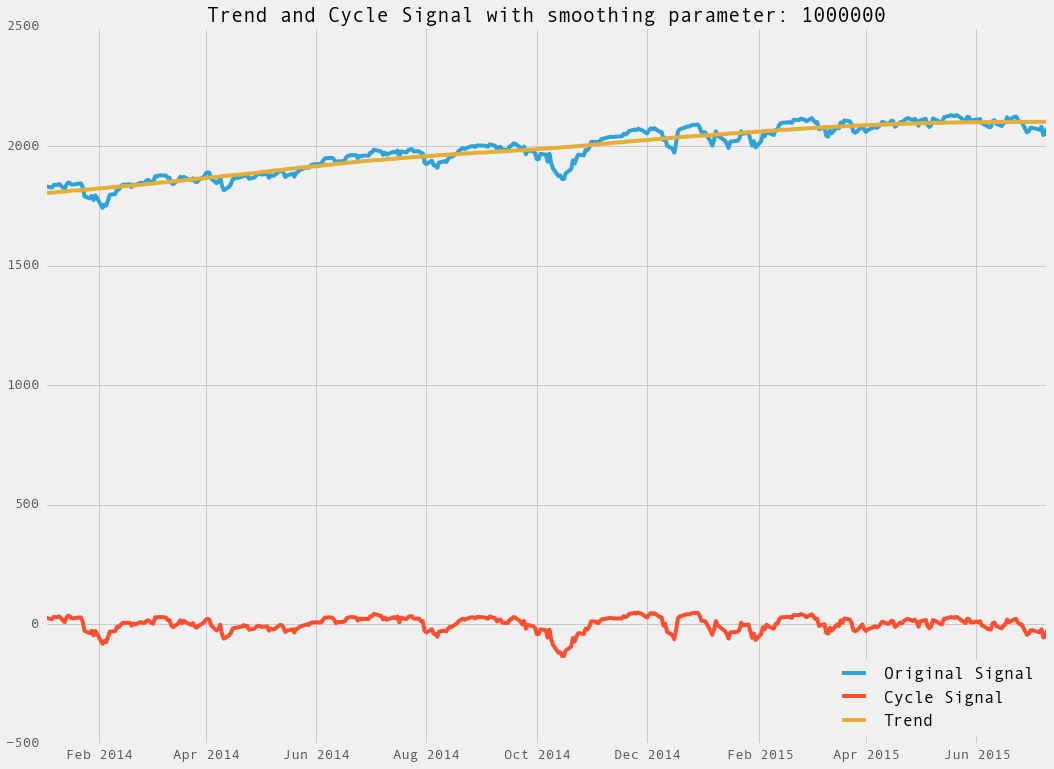

In [17]:
lamb = int(1e6)
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df.Close, lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

#### Good to Know for HP Filter
- Linear
- Decomposes the signal into two distinct components(trend and cycle)
- Cycle part => short term, season
- Trend part => medium to long term
- With changing regularizer, smoothing can be adjusted in the signal
- Bandpass filter is at its heart
- Perfect for signals that show seasonality
- Yields good results when noise is normally distributed

## $l_1$ Trend Filtering



- Optimization function:
$$ \frac{1}{2} \lVert x - y \rVert_2^2 + \lambda \lVert Dx \rVert_1$$
where  $x,y \in \mathbf{R}^n$, $\lambda \in \mathbf{R}_+^n$ and $D \in \mathbf{R}^{(n-2) x n}$ is the second order difference matrix

- [Project Page](http://stanford.edu/~boyd/papers/l1_trend_filter.html)
- [Paper](http://web.stanford.edu/~gorin/papers/l1_trend_filter.pdf)

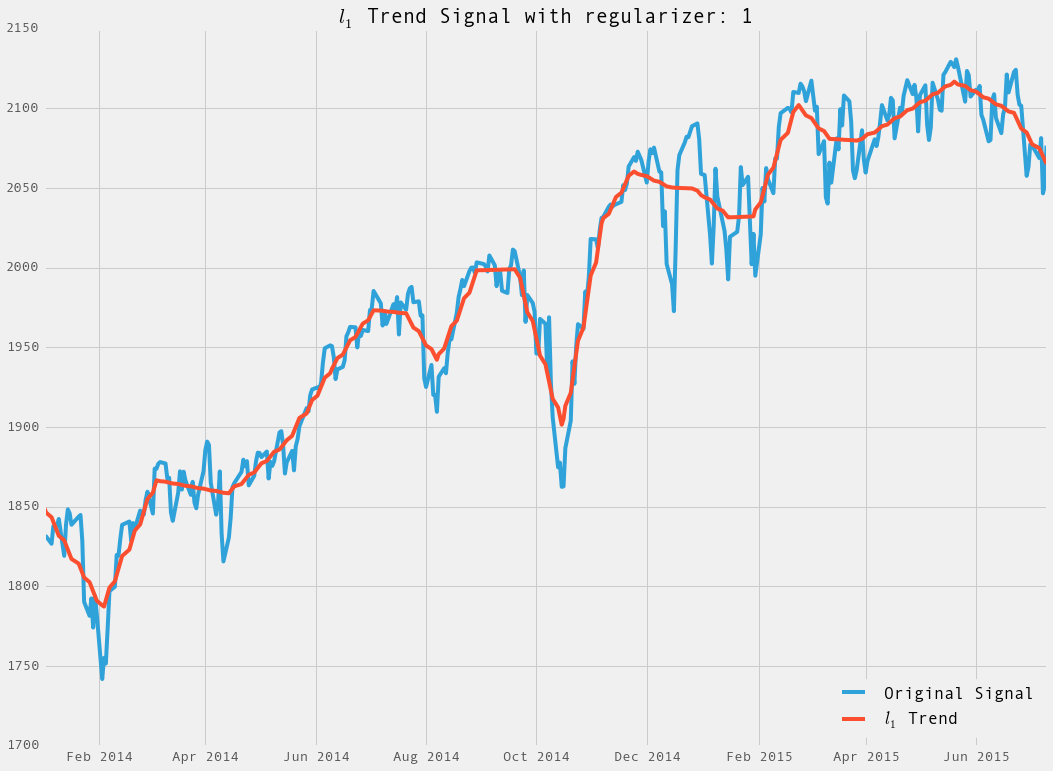

In [18]:
regularizer = 1
title = _L1_TITLE_TEMPLATE(regularizer)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, l1(df.Close.values, regularizer), '-', label=_L1_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

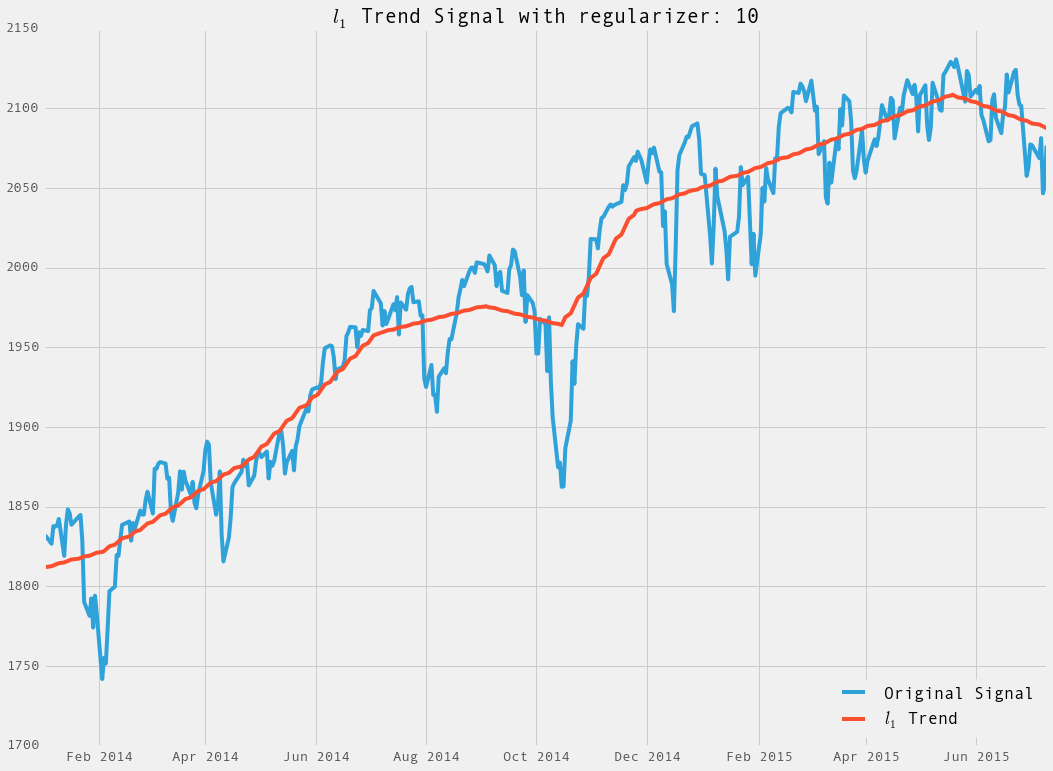

In [19]:
regularizer = 10
title = _L1_TITLE_TEMPLATE(regularizer)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, l1(df.Close.values, regularizer), '-', label=_L1_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

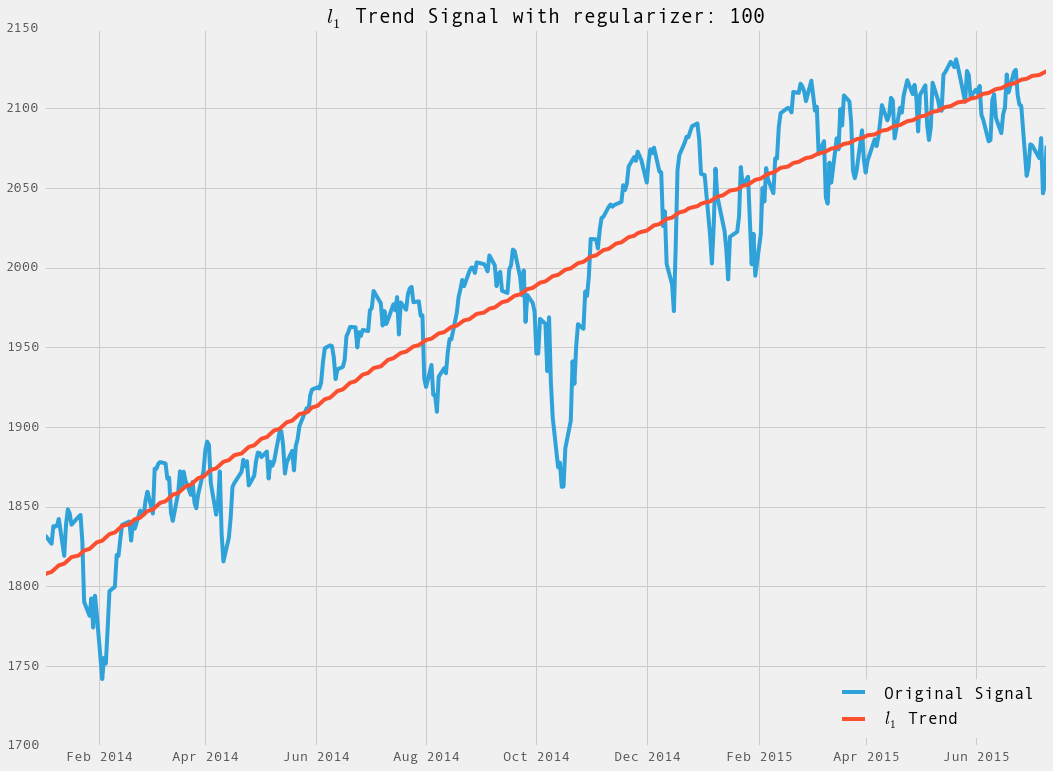

In [20]:
regularizer = 100
title = _L1_TITLE_TEMPLATE(regularizer)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, l1(df.Close.values, regularizer), '-', label=_L1_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

#### Good to Know for $l_1$ trend filtering
- Nonlinear
- Trend is piecewise linear, generally very smooth
- The kinks, or changes in slope of the estimated trend show abrupt events
- Changes in trend could be used for outlier detection
- Computationally a little bit expensive.
- Yields good results when noise is exponentially distributed

## Bandpass Filtering
Bandpass filters allow certain frequencies of the signal(between `low cutoff frequency` and `high cutoff frequency`) and attenuates the other frequencies. By doing so, one can prepare different bandpass filters to stop a particular band as well(called band-stop filter). If the signal is very volatile(high frequency) and you want to also remove the bias(low frequency), then bandpass filter provides a nice sweet spot to remove/attenuate low frequency and high frequency in the signal. If you consider Hodrick-Prescott filter as a band-pass filter, it extracts mid-term trend by removing very small changes(bias) and extracting short-term changes(cycle).


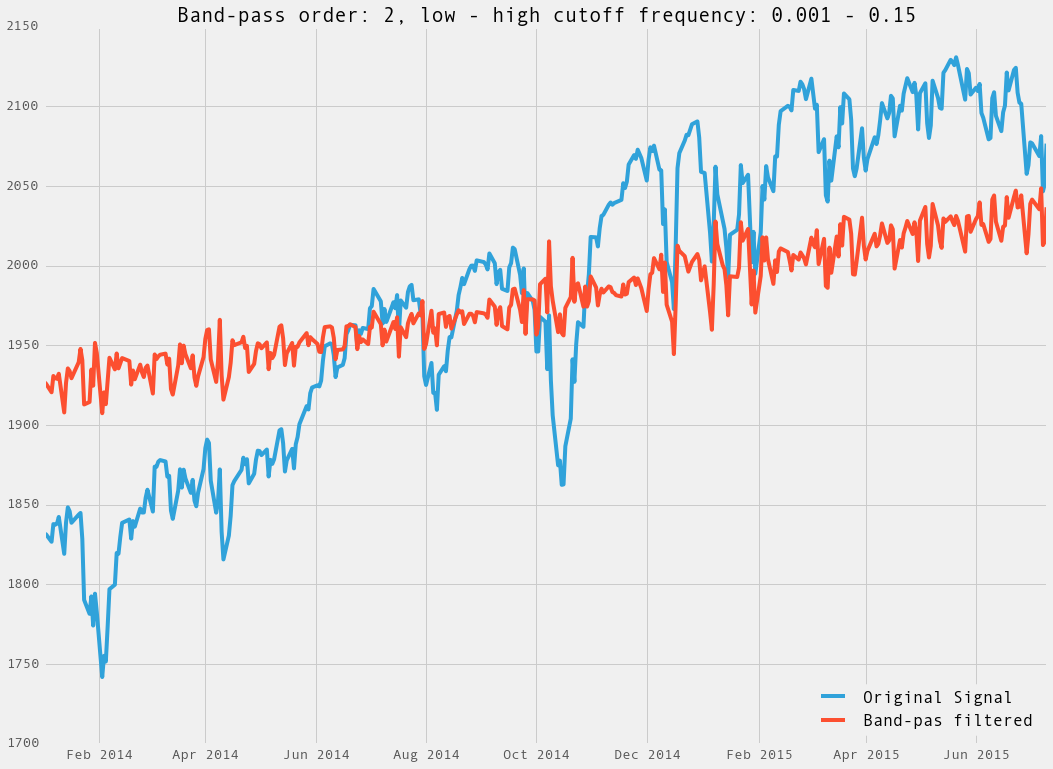

In [21]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.15
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df.Close.values)

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df.Close-bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

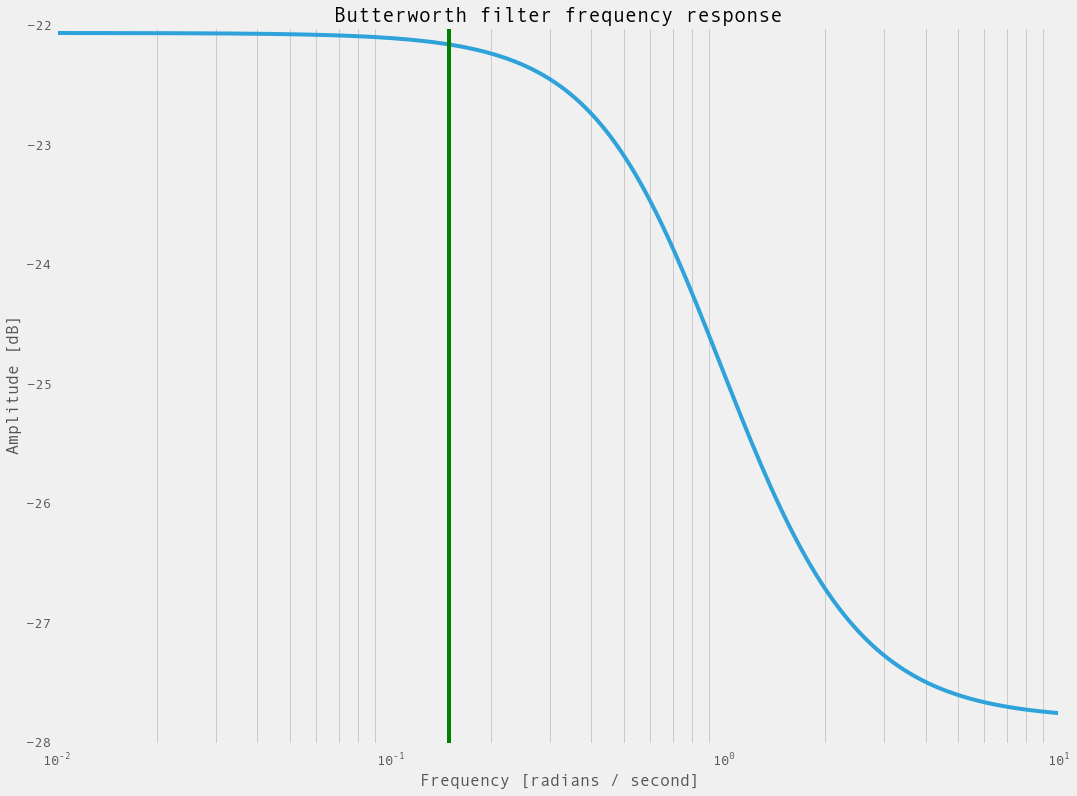

In [22]:
w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

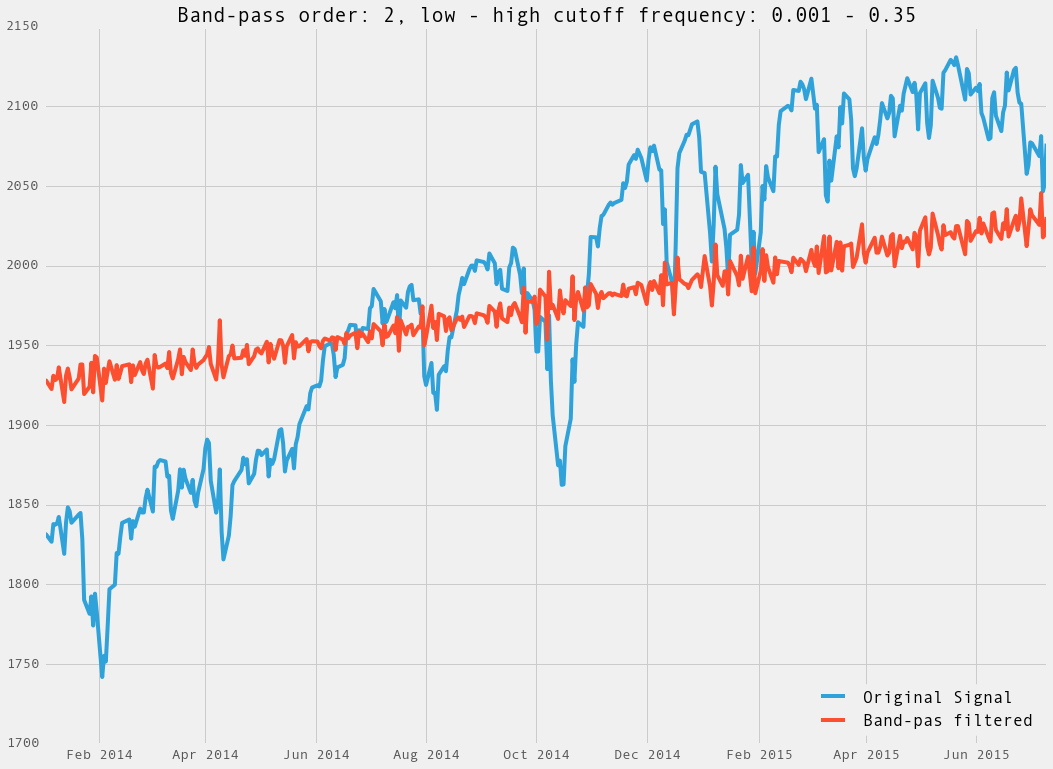

In [23]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.35
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df.Close.values)

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df.Close - bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

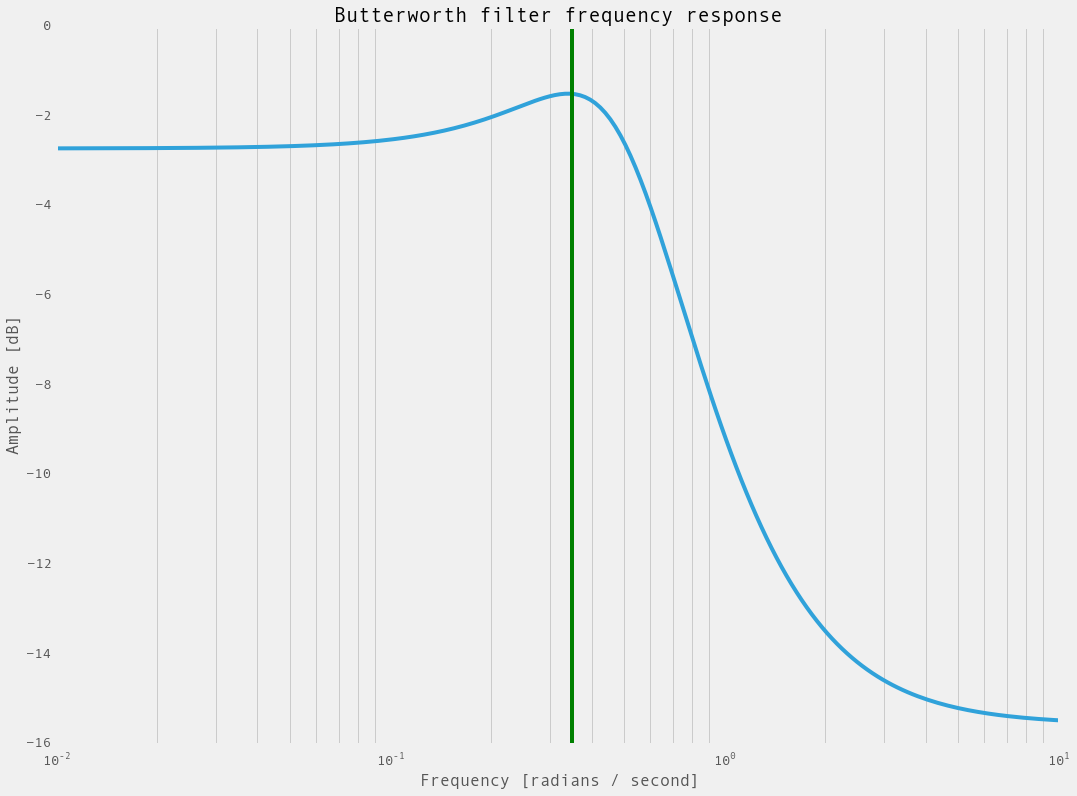

In [24]:
w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

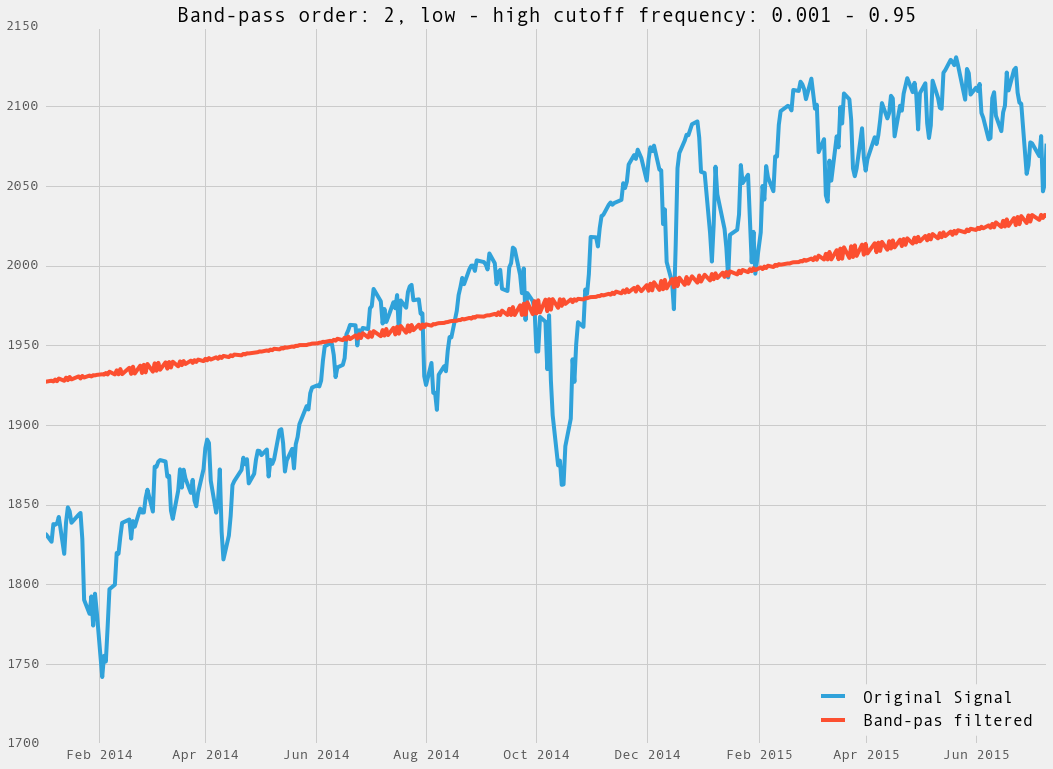

In [25]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.95
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df.Close.values)

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df.Close, '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df.Close - bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

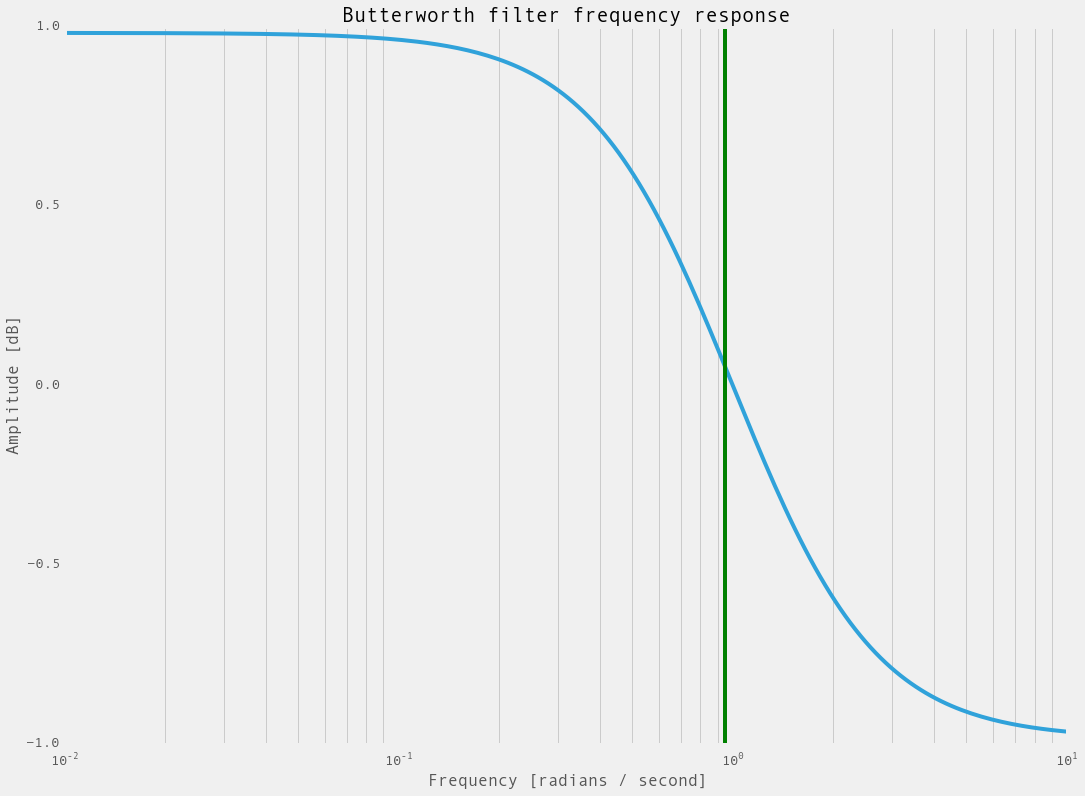

In [26]:
w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

#### Good to Know for Bandpass Filtering
- Allow certain frequencies of the signal(between `low cutoff frequency` and `high cutoff frequency`) and attenuates the other frequencies.
- This provides a flexible way to remove/attenuate low frequency(very long term) and high frequency(short-term) in the signal.
- Could prepare different filters to stop a particular band as well(called band-stop filter).
- Similar to Hodrick-Prescott Filter, it extracts mid-term trend by removing very small changes(bias) and extracting short-term changes(cycle).
